# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import matplotlib.pyplot as plt
from collections import Counter

# Loading Dataset

In [2]:
with open('dataset/text_classification_dataset.json', 'r', encoding='utf-8') as file:
    train_data = json.load(file)

texts = [d['text'] for d in train_data]
labels = [d['label'] for d in train_data]

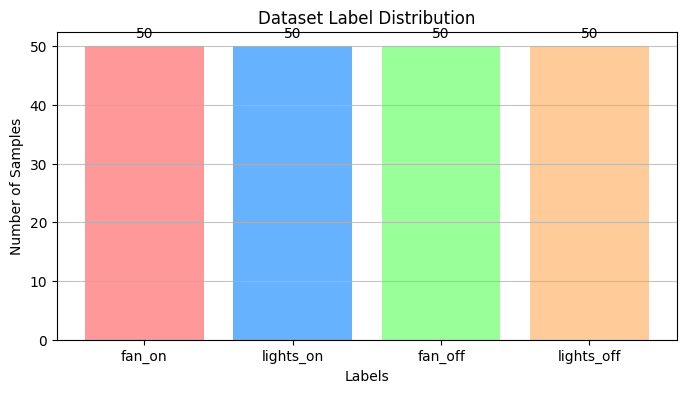

In [3]:
# Extract labels
labels = [item['label'] for item in train_data]

# Count occurrences of each label
label_counts = Counter(labels)

# Prepare data for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create bar plot
plt.figure(figsize=(8, 4))
plt.bar(label_names, label_values, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Dataset Label Distribution')
plt.grid(axis='y', alpha=0.75)

# Add value labels on top of each bar
for i, v in enumerate(label_values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

Spliting dataset to train and test.

In [4]:
# Convert labels to numerical values
label_map = {"lights_on": 0, "lights_off": 1, "fan_on": 2, "fan_off": 3}
y = [label_map[label] for label in labels]

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(texts).toarray()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Dataset Module

In [5]:
# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model

In [8]:
# Neural Network Model
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Training

## Hyperparameters

In [7]:
# Hyperparameters
input_size = X.shape[1]  # Number of TF-IDF features
hidden_size = 20
num_classes = 4
learning_rate = 0.01
num_epochs = 100
batch_size = 4

## Loading Dataset

In [8]:
# Create data loaders
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Initialize Model and Training

In [9]:
# Initialize model, loss, and optimizer
model = TextClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Lists to store loss values for plotting
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

Epoch [20/100], Loss: 0.0016
Epoch [40/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0000


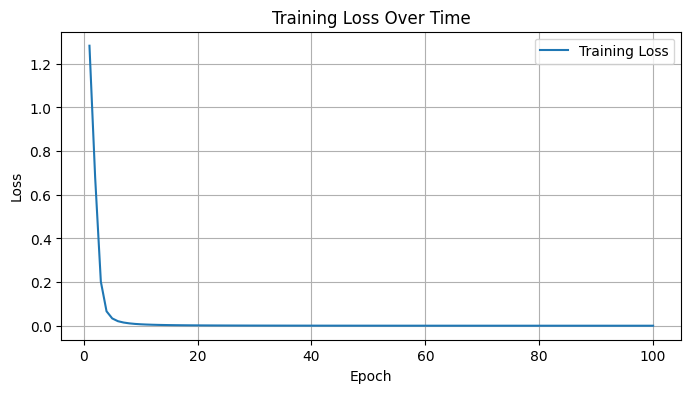

In [11]:
# Plotting the training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [12]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Test the model
accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 100.00%


# Inference

In [13]:
# Function to predict new text
def predict_text(text, model, vectorizer):
    model.eval()
    # Transform new text using the same vectorizer
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vector)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)
    
    reverse_map = {0: "lights_on", 1: "lights_off", 2: "fan_on", 3: "fan_off"}
    return reverse_map[predicted.item()]

# Example prediction
new_text = "please turn on the fan"
prediction = predict_text(new_text, model, vectorizer)
print(f'Prediction for "{new_text}": {prediction}')

Prediction for "please turn on the fan": fan_on


## Saving Model

In [14]:
def save_model(model, vectorizer, path="model/text_classifier_model"):
    # Create a dictionary with state dict and architecture parameters
    save_dict = {
        'state_dict': model.state_dict(),
        'input_size': model.layer1.in_features,
        'hidden_size': model.layer1.out_features,
        'num_classes': model.layer2.out_features
    }
    
    # Save the model dictionary
    torch.save(save_dict, f"{path}.pth")
    
    # Save the vectorizer separately
    with open(f"{path}_vectorizer.pkl", 'wb') as f:
        pickle.dump(vectorizer, f)
    print(f"Model saved to {path}.pth and vectorizer to {path}_vectorizer.pkl")

# Save the model after training
save_model(model, vectorizer)

Model saved to model/text_classifier_model.pth and vectorizer to model/text_classifier_model_vectorizer.pkl


# Loading Model and Inference

In [9]:
def load_model(model_class, model_path="model/text_classifier_model.pth", vectorizer_path="model/text_classifier_model_vectorizer.pkl"):
    # Load the saved dictionary
    saved_data = torch.load(model_path)
    
    # Extract architecture parameters
    input_size = saved_data['input_size']
    hidden_size = saved_data['hidden_size']
    num_classes = saved_data['num_classes']
    
    # Initialize the model with the saved parameters
    loaded_model = model_class(input_size, hidden_size, num_classes)
    
    # Load the state dictionary
    loaded_model.load_state_dict(saved_data['state_dict'])
    loaded_model.eval()  # Set to evaluation mode
    
    # Load the vectorizer
    with open(vectorizer_path, 'rb') as f:
        loaded_vectorizer = pickle.load(f)
    
    return loaded_model, loaded_vectorizer

In [10]:
# Example of how to use the loaded model
def predict_with_loaded_model(text, model, vectorizer):
    model.eval()
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vector)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)
    
    reverse_map = {0: "lights_on", 1: "lights_off", 2: "fan_on", 3: "fan_off"}
    return reverse_map[predicted.item()]

## Inference with loaded model

In [11]:
# After training and saving, you can later load it like this:
loaded_model, loaded_vectorizer = load_model(TextClassifier)

# Test the loaded model
test_text = "turn on the fan now"
prediction = predict_with_loaded_model(test_text, loaded_model, loaded_vectorizer)
print(f'Prediction for "{test_text}" with loaded model: {prediction}')

Prediction for "turn on the fan now" with loaded model: fan_on


C:\Users\quang\AppData\Local\Temp\ipykernel_14212\3431268960.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(model_path)
